## Extractive Summarization Inference 

In this notebook we will 

- Load a pretrained Pytorch model for **extractive** summarization 
- Perform inference and visualize sentence scores.
- Build a simple pipleline for **abstractive** summarization using HuggingFace transformers
- Load live news articles from [TechCrunch](https://techcrunch.com/) and summarize them using both our extractive and abstractive model .

In [1]:
!python -m spacy download en_core_web_lg

C:\Users\User\AppData\Local\Programs\Python\Python310\python.exe: No module named spacy


In [2]:
!pip install -q transformers  rouge-score sentence-transformers

^C


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from tqdm.notebook import tqdm
 
import plotly.express as px

import os 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
 
from transformers import AutoTokenizer, AutoModel 
nlp = spacy.load('en_core_web_lg')

In [2]:
# get mean pooling for sentence bert models 
# ref https://www.sbert.net/examples/applications/computing-embeddings/README.html#sentence-embeddings-with-transformers
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class SentenceBertClass(torch.nn.Module):
    def __init__(self, model_name="sentence-transformers/paraphrase-MiniLM-L3-v2"):
        super(SentenceBertClass, self).__init__()
        self.l1 = AutoModel.from_pretrained(model_name)
        self.pre_classifier = torch.nn.Linear(384*3, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 1)
        self.classifierSigmoid = torch.nn.Sigmoid()

    def forward(self, sent_ids, doc_ids, sent_mask, doc_mask):

        sent_output = self.l1(input_ids=sent_ids, attention_mask=sent_mask) 
        sentence_embeddings = mean_pooling(sent_output, sent_mask) 

        doc_output = self.l1(input_ids=doc_ids, attention_mask=doc_mask) 
        doc_embeddings = mean_pooling(doc_output, doc_mask)

        # elementwise product of sentence embs and doc embs
        combined_features = sentence_embeddings * doc_embeddings  

        # get concat of both features and elementwise product
        feat_cat = torch.cat((sentence_embeddings, doc_embeddings, combined_features), dim=1)  
        
        pooler = self.pre_classifier(feat_cat) 
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.classifierSigmoid(output) 

        return output

In [ ]:
#model path .. modify to location of trained model file 
model_path = "drive/MyDrive/mlexperiments/extractivesummarization/models/minilm_bal_exsum.pth"

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

extractive_model = SentenceBertClass() 
# extractive_model.load_state_dict(torch.load(model_path, map_location=torch.device(device) ))
extractive_model.eval(); 

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

D:\School\4Year_2sem\Thesis\text_summarization\venv\lib\site-packages\huggingface_hub\file_download.py:127: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

## Extractive Summarization Inference 



In [4]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-MiniLM-L3-v2')

# tokenize text as required by BERT based models
def get_tokens(text, tokenizer):
  inputs = tokenizer.batch_encode_plus(
            text, 
            add_special_tokens=True,
            max_length=512,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
  ids = inputs['input_ids']
  mask = inputs['attention_mask']
  return ids, mask

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [5]:
# get predictions given some an array of sentences and their corresponding documents
def predict(model,sents, doc):
  sent_id, sent_mask = get_tokens(sents,tokenizer)
  sent_id, sent_mask = torch.tensor(sent_id, dtype=torch.long),torch.tensor(sent_mask, dtype=torch.long)
 
  doc_id, doc_mask = get_tokens([doc],tokenizer)
  doc_id, doc_mask = doc_id * len(sents), doc_mask* len(sents)
  doc_id, doc_mask = torch.tensor(doc_id, dtype=torch.long),torch.tensor(doc_mask, dtype=torch.long)

  preds = model(sent_id, doc_id, sent_mask, doc_mask)
  return preds

In [6]:
def summarize(doc, model, min_sentence_length=14, top_k=3, batch_size=3):
  doc = doc.replace("\n","")
  doc_sentences = []
  for sent in nlp(doc).sents:
    if len(sent) > min_sentence_length: 
      doc_sentences.append(str(sent))
  
  doc_id, doc_mask = get_tokens([doc],tokenizer)
  doc_id, doc_mask = doc_id * batch_size, doc_mask* batch_size
  doc_id, doc_mask = torch.tensor(doc_id, dtype=torch.long),torch.tensor(doc_mask, dtype=torch.long)

  scores = [] 
  # run predictions using some batch size
  for i in tqdm(range(int(len(doc_sentences) / batch_size) + 1)):
    batch_start = i*batch_size  
    batch_end = (i+1) * batch_size if (i+1) * batch_size < len(doc) else len(doc)-1
    batch = doc_sentences[batch_start: batch_end]
    if batch:
      preds = predict(model, batch, doc) 
      scores = scores + preds.tolist() 
 
  sent_pred_list = [{"sentence": doc_sentences[i], "score": scores[i][0], "index":i} for i in range(len(doc_sentences))]
  sorted_sentences = sorted(sent_pred_list, key=lambda k: k['score'], reverse=True) 

  sorted_result = sorted_sentences[:top_k] 
  sorted_result = sorted(sorted_result, key=lambda k: k['index']) 
  
  summary = [ x["sentence"] for x in sorted_result]
  summary = " ".join(summary)

  return summary, scores, doc_sentences


In [7]:
article = """ Birds are a group of warm-blooded vertebrates constituting the class Aves /ˈeɪviːz/, characterised by feathers, toothless beaked jaws, the laying of hard-shelled eggs, a high metabolic rate, a four-chambered heart, and a strong yet lightweight skeleton. Birds live worldwide and range in size from the 5.5 cm (2.2 in) bee hummingbird to the 2.8 m (9 ft 2 in) ostrich. There are about ten thousand living species, more than half of which are passerine, or “perching” birds. Birds have wings whose development varies according to species; the only known groups without wings are the extinct moa and elephant birds. Wings, which evolved from forelimbs, gave birds the ability to fly, although further evolution has led to the loss of flight in some birds, including ratites, penguins, and diverse endemic island species. The digestive and respiratory systems of birds are also uniquely adapted for flight. Some bird species of aquatic environments, particularly seabirds and some waterbirds, have further evolved for swimming. Birds are feathered theropod dinosaurs and constitute the only known living dinosaurs. Likewise, birds are considered reptiles in the modern cladistic sense of the term, and their closest living relatives are the crocodilians. Birds are descendants of the primitive avialans (whose members include Archaeopteryx) which first appeared about 160 million years ago (mya) in China. According to DNA evidence, modern birds (Neornithes) evolved in the Middle to Late Cretaceous, and diversified dramatically around the time of the Cretaceous–Paleogene extinction event 66 mya, which killed off the pterosaurs and all known non-avian dinosaurs. Many social species pass on knowledge across generations, which is considered a form of culture. Birds are social, communicating with visual signals, calls, and songs, and participating in such behaviours as cooperative breeding and hunting, flocking, and mobbing of predators. The vast majority of bird species are socially (but not necessarily sexually) monogamous, usually for one breeding season at a time, sometimes for years, but rarely for life. Other species have breeding systems that are polygynous (one male with many females) or, rarely, polyandrous (one female with many males). Birds produce offspring by laying eggs which are fertilised through sexual reproduction. They are usually laid in a nest and incubated by the parents. Most birds have an extended period of parental care after hatching. Many species of birds are economically important as food for human consumption and raw material in manufacturing, with domesticated and undomesticated birds being important sources of eggs, meat, and feathers. Songbirds, parrots, and other species are popular as pets. Guano (bird excrement) is harvested for use as a fertiliser. Birds figure throughout human culture. About 120 to 130 species have become extinct due to human activity since the 17th century, and hundreds more before then. Human activity threatens about 1,200 bird species with extinction, though efforts are underway to protect them. Recreational birdwatching is an important part of the ecotourism industry. """

In [8]:
article

' Birds are a group of warm-blooded vertebrates constituting the class Aves /ˈeɪviːz/, characterised by feathers, toothless beaked jaws, the laying of hard-shelled eggs, a high metabolic rate, a four-chambered heart, and a strong yet lightweight skeleton. Birds live worldwide and range in size from the 5.5 cm (2.2 in) bee hummingbird to the 2.8 m (9 ft 2 in) ostrich. There are about ten thousand living species, more than half of which are passerine, or “perching” birds. Birds have wings whose development varies according to species; the only known groups without wings are the extinct moa and elephant birds. Wings, which evolved from forelimbs, gave birds the ability to fly, although further evolution has led to the loss of flight in some birds, including ratites, penguins, and diverse endemic island species. The digestive and respiratory systems of birds are also uniquely adapted for flight. Some bird species of aquatic environments, particularly seabirds and some waterbirds, have furt

## Inference - Generate Extractive Summary

- Perform inference
- Make sense of model results by visualizing scores assigned to each sentence.

In [9]:
summary, scores, sentences = summarize(article, extractive_model, min_sentence_length=14, top_k=3, batch_size=4)
summary

  0%|          | 0/5 [00:00<?, ?it/s]

' Birds are a group of warm-blooded vertebrates constituting the class Aves /ˈeɪviːz/, characterised by feathers, toothless beaked jaws, the laying of hard-shelled eggs, a high metabolic rate, a four-chambered heart, and a strong yet lightweight skeleton. According to DNA evidence, modern birds (Neornithes) evolved in the Middle to Late Cretaceous, and diversified dramatically around the time of the Cretaceous–Paleogene extinction event 66 mya, which killed off the pterosaurs and all known non-avian dinosaurs. About 120 to 130 species have become extinct due to human activity since the 17th century, and hundreds more before then.'

Among them were Navy medic Max Soviak, and Marines Hunter Lopez, Rylee McCollum, David Lee Espinoza, Kareem Nikoui, Jared Schmitz, Ryan Knauss, Daegan Page, Taylor Hoover and an unnamed special forces soldier. McCollum's wrestling coach and a close family friend told DailyMail.com that 'heads should roll' over the debacle. McCollum was named by his high school in Wyoming while Espinoza, 20, was named by the local police department in Laredo, Texas, where he was born.

## Visualize Scores Assigned to Each Sentence  

A visualization of the scores assigned by the model can help us "make sense" of model behaviour. 

- is the model weighting each sentence equally or focusing on some sentences? (ideally, we want to see good variation). 


findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font fam

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font fam

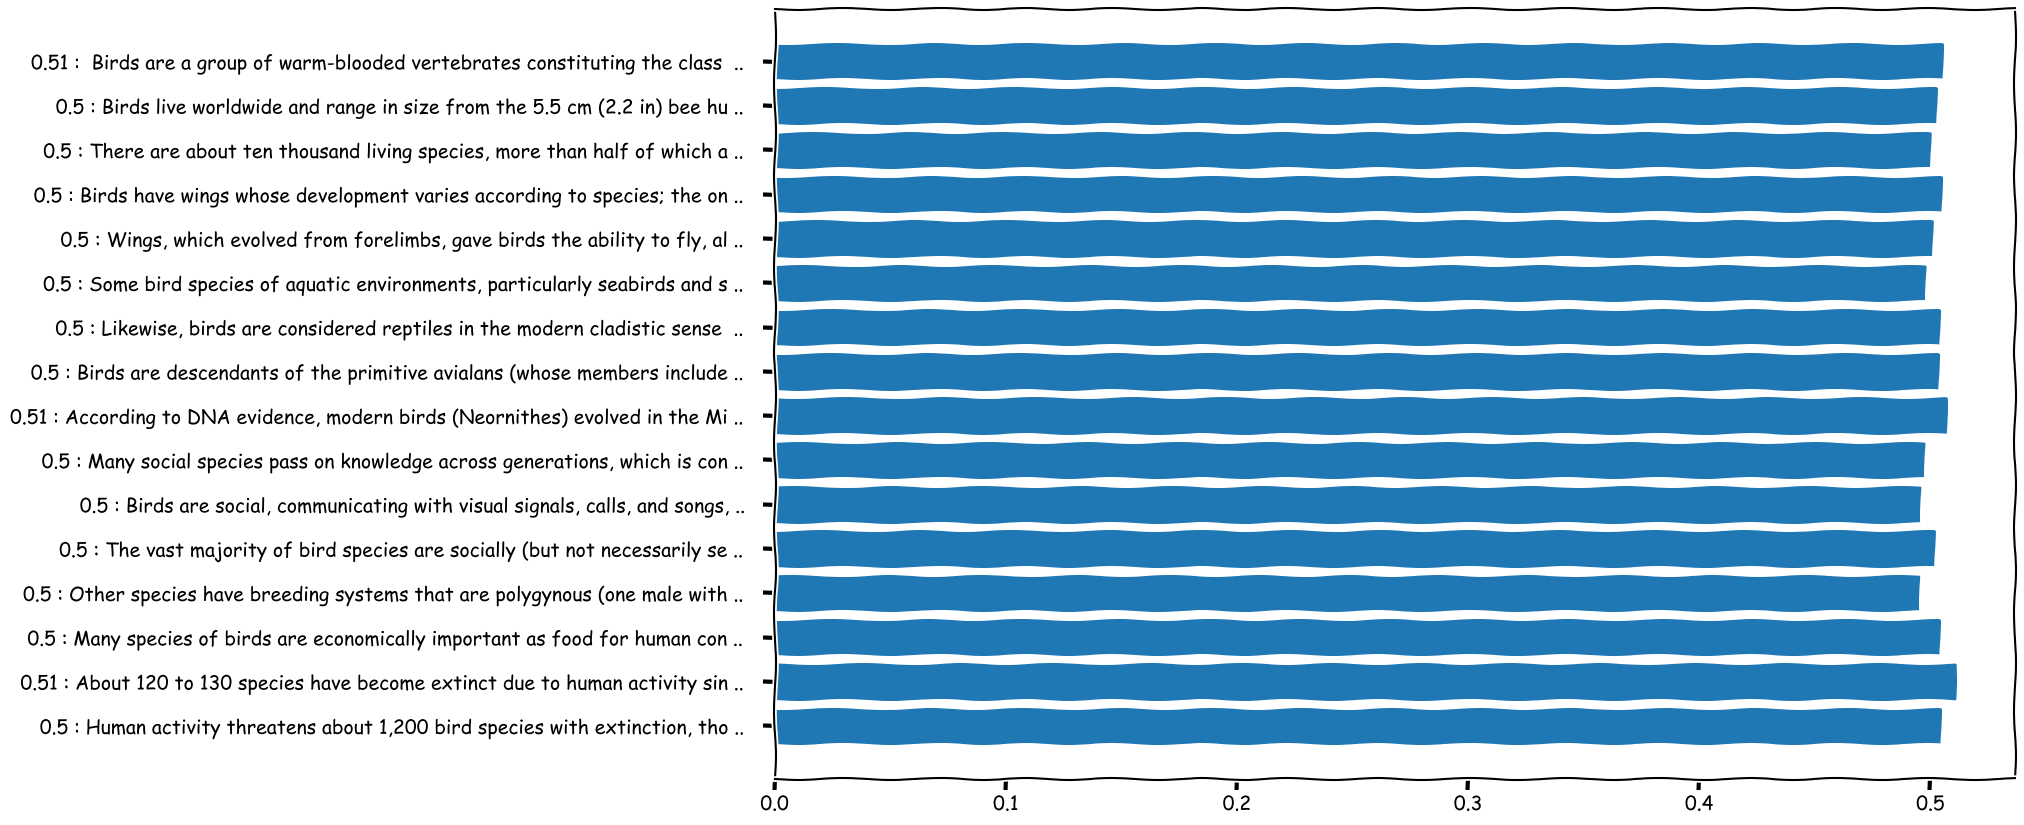

In [10]:
sent_lenth = 70
score_vals = ([x[0] for x in scores] ) 
sub_sents = [ str(round(score_vals[i],2)) + " : " + sentences[i][:sent_lenth] + " ..  " for i in range(len(sentences))] 
with plt.xkcd():
    plt.figure(figsize=(16,10));
    plt.barh(sub_sents[::-1], score_vals[::-1]);

## Scrape some Tech News and Summarize 

- Get a list of articles on front page of TechCrunch news
- Get each article's title, and content using urlib and beatifulsoup.

In [11]:
from bs4 import BeautifulSoup
import urllib.request

import json

def save_json(data, file_path): 
  with open(file_path, 'w', encoding='utf-8') as f:
      json.dump(data, f, ensure_ascii=False, indent=4)

In [37]:
def get_article(page_url):
  page =  urllib.request.urlopen(page_url)
  soup = BeautifulSoup(page, "html.parser")
  content = soup.find("div", attrs={"class": "article-content"})
  content = content.text.replace("\n","").replace("\xa0","").strip()
  return content

main_page =  urllib.request.urlopen("https://techcrunch.com/")
articles = BeautifulSoup(main_page, "html.parser")
articles = articles.find("div", attrs={"id": "root"}).find_all("a", attrs={"class": "post-block__title__link"})

article_contents = [ get_article(x["href"]) for x in articles] 
article_titles = [ x.text.replace("\t","").strip() for x in articles] 

## Abstractive Summarization with HF for Comparison

In [28]:
# cnnPdf = pd.read_csv("../cnn_dailymail/test.csv")
# cnnPdf["article"]

# article_contents = cnnPdf["article"].to_numpy()
# article_titles = cnnPdf["highlights"].to_numpy()

In [29]:
from transformers import pipeline
from tqdm import tqdm
ab_summarizer = pipeline("summarization", model="t5-base")
import re 


D:\School\4Year_2sem\Thesis\text_summarization\venv\lib\site-packages\transformers\models\t5\tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [30]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

abs_model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")
abs_tokenizer = AutoTokenizer.from_pretrained("t5-base")



In [35]:
def abstractive_summarize(doc,  max_length=250, min_length=50, batch_size=2):
  all_sum=[]
  # batched prediction
  for i in tqdm(range(int(len(doc) / batch_size) + 1)): 
    batch_start = i*batch_size  
    batch_end = (i+1) * batch_size if (i+1) * batch_size < len(doc) else len(doc)
    batch = ["summarize: " + x for x in doc[batch_start: batch_end]]   
    if (batch):
      inputs = abs_tokenizer.batch_encode_plus( batch, return_tensors="pt", max_length=512, truncation=True, padding=True) 
      outputs = abs_model.generate(inputs["input_ids"], max_length=max_length, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
      output = [re.sub(r'<([^>]*)>', "", abs_tokenizer.decode(x))  for x in outputs.tolist()]  
      all_sum = all_sum + output 
  return all_sum

In [38]:
ab_summary = abstractive_summarize(article_contents)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:25<00:00, 12.09s/it]


In [39]:
 (ab_summary)

[' Tesla reported 405,278 vehicles delivered in the fourth quarter of 2022. it came in shy of expectations of around 420,000 to 425,000 units delivered. the company also reported total production of 439,701 vehicles in the quarter.',
 ' Tesla reported 405,278 vehicles delivered in the fourth quarter of 2022. it came in shy of expectations of around 420,000 to 425,000 units delivered. the company also reported total production of 439,701 vehicles in the quarter.',
 " entrepreneurs are trying to match demand with untapped assets and services. the model might sound counterintuitive to people in the west, but Southeast Asia's medical system is built on very different patient-hospital dynamics. forty percent of Southeast Asia’s health spending was paid out of pocket in 2018.",
 ' suhail Sameer, the chief executive of BharatPe, will leave the top role later this week. he will transition to a strategic advisor role on January 7. current chief financial officer Nalin Negi will take over as int

In [40]:
ex_summary =  [summarize(x, extractive_model)[0] for x in article_contents ]

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:17<00:00,  1.10it/s]


In [41]:
ex_summary

['The automaker needed to sell 495,760 vehicles in Q4 to have achieved that guidance. The automaker’s last minute discounts might have given Tesla a boost towards the end of the quarter. This article has been updated to clarify that the stock market is closed on Monday.',
 'The automaker needed to sell 495,760 vehicles in Q4 to have achieved that guidance. The automaker’s last minute discounts might have given Tesla a boost towards the end of the quarter. This article has been updated to clarify that the stock market is closed on Monday.',
 'Since there’s no central platform providing cost transparency, patients often end up paying a steep price. Patients getting surgeries such as thyroid, hemorrhoid, and orthopedic surgery through HD are paying 15-20% less than market prices. “But in Thailand, Indonesia, and Vietnam, you can get that tier of medication at pharmacies [over the counter], removing the need for telehealth.',
 'We look forward to supporting Nalin Negi in his role as the in

In [42]:
all_sum = [ {"title": article_titles[i], "content": article_contents[i], "abstractive": ab_summary[i], "extractive": ex_summary[i]} for i in range(len(article_contents))]
save_json(all_sum,"samples.json")

In [43]:
df = pd.DataFrame.from_dict(all_sum)
df

,title,content,abstractive,extractive
0,"Tesla delivers 405,278 vehicles in Q4, missing...","Tesla reported Monday 405,278 vehicles deliver...","Tesla reported 405,278 vehicles delivered in ...","The automaker needed to sell 495,760 vehicles ..."
1,,"Tesla reported Monday 405,278 vehicles deliver...","Tesla reported 405,278 vehicles delivered in ...","The automaker needed to sell 495,760 vehicles ..."
2,This startup brings Southeast Asia’s vacant ho...,Uber and Airbnb have long been the poster chil...,entrepreneurs are trying to match demand with...,Since there’s no central platform providing co...
3,Indian fintech BharatPe CEO Suhail Sameer to l...,"Suhail Sameer, the chief executive of BharatPe...","suhail Sameer, the chief executive of BharatP...",We look forward to supporting Nalin Negi in hi...
4,Startups set to go to space for the first time...,SpaceX is poised to launch 114 payloads to orb...,"launcher's tug, called Orbiter, will deploy o...","Those startups include Launcher, which is cond..."
5,Max Q: 2022 was big. 2023 will be even bigger.,Hello and welcome back to Max Q. I hope everyo...,it was a big year for the space industry. 202...,"There’s alotto look forward to — so much, that..."
6,"Tesla delivers 405,278 vehicles in Q4, missing...","Tesla reported Monday 405,278 vehicles deliver...","Tesla reported 405,278 vehicles delivered in ...","The automaker needed to sell 495,760 vehicles ..."
7,Product-led growth and profitability: What’s g...,"Among public tech companies, “product-led grow...",product-led growth (PLG) companies operate at...,"Among public tech companies, “product-led grow..."
8,Fintech predictions and opportunities for 2023,Victoria TreygerContributorShare on Twitter \t...,fintech has fallen a long way from the highs ...,Larger companies are more likely to cut back o...
9,What to expect from the creator economy in 2023,Social media platforms and creator-focused sta...,creators are continuing to make a living outs...,"This is huge, because it’s an open secret that..."
